In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.integrate as intg

### This code follows the Zhang 2018 paper on IA self-calibration

#### - the "chi's" are all computed in unit of c/H0

In [3]:
#constants
Omega0 = 0.3 #present day matter density in unit of critical density
OmegaLambda = 0.7 
Omegak = 1-Omega0-OmegaLambda

deltaz = 0.2 #redshift bin width
z_limit = 20

#functions
def z_i_center(i): #the center for the ith redshift bin
    return 0.2*(i+1)

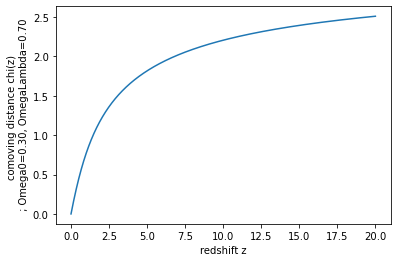

In [12]:
#comoving distance function, in unit of c/H0
#Troxel and Ishak 2014 equation (8) without the factor of H0
def chi_integrand(z):
    return 1/np.sqrt(Omega0*(1+z)**3+Omegak*(1+z)**2+OmegaLambda)
def chi(z):
    return intg.quad(chi_integrand,0,z)[0]

z_list = np.linspace(0,z_limit,z_limit*1000) #tabulate chi in intervals of 0.001
chi_list = np.array([])
for z in z_list: chi_list = np.append(chi_list,chi(z))
plt.plot(z_list, chi_list)
plt.xlabel('redshift z')
plt.ylabel('comoving distance chi(z) \n ; Omega0=%1.2f, OmegaLambda=%1.2f' %(Omega0,OmegaLambda))
plt.show()

In [21]:
#Gaussian Photo-Z PDF
def sigma_p(z):
    #Zhang 2018 discusses when 0.05->0.03 accuracy improves by 2.3x on page 7 bottom right
    return 0.05*(1+z)
def photozPDF(ztrue,zphoto):
    #??? The photo-z PDF has sigma_p(z), is it sigma_p(ztrue) or sigma_p(zphoto)?
    std = sigma_p(ztrue)
    return 1/(np.sqrt(2*np.pi)*std)*np.exp(-(zphoto-ztrue)**2/(2*std**2))
#testing the gaussian PDF normalization
# def gaussian_test(x,center=3,width=4):
#     import numpy as np
#     return 1/(np.sqrt(np.pi)*width)*np.exp(-((x-center)/width)**2)
# z_test = np.linspace(-10,10,500)
# n_z_test = gaussian_test(z_test,3,4)
# plt.ylim(0,0.3)
# plt.plot(z_test, n_z_test)
# intg.quad(gaussian_test,-100,100)

In [20]:
#Lensing kernel
def W_L(z_L,z_G):
    if z_L<z_G:
        z_L_index = np.floor(z_L/0.001)
        z_G_index = np.floor(z_L/0.001)
        return 3*Omega0/2 * (1+z_L)*chi(z_L)*(1-chi(z_L)/chi(z_G))
    else: return 0 
print(W_L(1,2))
def W_L(z_L,z_G):
    if z_L<z_G:
        z_L_index = int(np.floor(z_L/0.001))
        z_G_index = int(np.floor(z_G/0.001))
        #print(z_L_index,z_G_index)
        return 3*Omega0/2 * (1+z_L)*chi_list[z_L_index]*(1-chi_list[z_L_index]/chi_list[z_G_index])
    else: return 0 
#print(W_L_bylist(1,2))

0.25145467930623694


In [23]:
i = 5
z_lowerbound = z_i_center(i)-deltaz/2
z_upperbound = z_i_center(i)+deltaz/2
print("calculating redshift bin %1.2f - %1.2f" %(z_lowerbound,z_upperbound))

#redshift distributions
def n_z(z):
    return z*z*np.exp(-z/0.5)
#galaxy distribution normalized in bin i    
n_z_i_norm = intg.quad(n_z,z_lowerbound,z_upperbound)[0]
def n_z_i(z):
    return z*z*np.exp(-z/0.5)/n_z_i_norm
#galaxy distribution normalized from 0 to infinity~z_limit
n_z_all_norm = intg.quad(n_z,0,z_limit)[0]
def n_z_all(z):
    return z*z*np.exp(-z/0.5)/n_z_all_norm

intg_steps = 21
z_intg_range = np.linspace(0,z_limit,intg_steps)
for i in range(intg_steps-1):
    z_intg_midpoint = (i+0.5)*z_limit/(intg_steps-1) #z value between z_intg_range[i] and z_intg_range[i+1]
    print(z_intg_midpoint)
    
    def upper_integrand(z_G,zphoto_g,zphoto_G): #defined for the ith redshift bin
        #setting z_L ~ z_g = z_intg_midpoint
        #the integration is performed on zphoto_g,z_G,and zphoto_G, after the integration, the dependency is on z_L ~= z_g only.
        if zphoto_G<zphoto_g:
            return 2*W_L(z_intg_midpoint,z_G)*photozPDF(z_G,zphoto_G)*photozPDF(z_intg_midpoint,zphoto_g)*n_z_i(zphoto_G)*n_z_i(zphoto_g)
        else: return 0
    def lower_integrand(z_G,zphoto_g,zphoto_G): #defined for the ith redshift bin
        return W_L(z_intg_midpoint,z_G)*photozPDF(z_G,zphoto_G)*photozPDF(z_intg_midpoint,zphoto_g)*n_z_i(zphoto_G)*n_z_i(zphoto_g)
    upper_integral = intg.tplquad(upper_integrand,z_lowerbound,z_upperbound,z_lowerbound,z_upperbound,0,z_limit)
    lower_integral = intg.tplquad(lower_integrand,z_lowerbound,z_upperbound,z_lowerbound,z_upperbound,0,z_limit)
    
    print(upper_integral,lower_integral)
    #eta = upperintegrand evaluated at z_midpoint / lower integrand evaluated at z_midpoint


calculating redshift bin 1.10 - 1.30
0.5
(5.861152352300179e-17, 1.5891757784433787e-12) (4.907712874709877e-16, 7.944869054882618e-13)
1.5


/Users/junzhezhou/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/quadpack.py:880: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


KeyboardInterrupt: 

In [46]:
photozPDF(1,1)
W_L(1,2)
n_z_i(1)

array([5.19101904e+00, 4.67565428e+14])